<a href="https://colab.research.google.com/github/Suhit97/Name-Entity-Recognition-/blob/master/NER%20using%20tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the dataset


[dataset link](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)

In [1]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [8]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus -p /content

 68% 18.0M/26.4M [00:00<00:00, 186MB/s]
100% 26.4M/26.4M [00:00<00:00, 169MB/s]


In [10]:
!unzip entity-annotated-corpus.zip -d /content/gdrive/My\ Drive/NER

Archive:  entity-annotated-corpus.zip
  inflating: /content/gdrive/My Drive/NER/ner.csv  
  inflating: /content/gdrive/My Drive/NER/ner_dataset.csv  


In [12]:
csv_path = '/content/gdrive/My Drive/NER/ner_dataset.csv'

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv(csv_path ,encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [14]:
words = list(set(data["Word"].values))
n_words = len(words);
n_words

35178

In [15]:
tags = list(set(data["Tag"].values))
n_tags = len(tags);
n_tags

17

In [17]:
class SentenceGetter(object):
    
    def __init__(self, data):
       self.n_sent = 1
       self.data = data
       self.empty = False
       agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
       self.grouped = self.data.groupby("Sentence #").apply(agg_func)
       self.sentences = [s for s in self.grouped]

    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None  

In [18]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [20]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [21]:
labels = [[s[2] for s in sent] for sent in sentences]
sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences[0]


'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [22]:
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


## Preprocessing the data
We first build a vocabulary of the most common 5000 words and map the rest to the “UNK” token.

In [24]:
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

word_cnt = Counter(data["Word"].values)
vocabulary = set(w[0] for w in word_cnt.most_common(5000))

Now we create the word index and pad the sequence to a common length.

In [25]:
max_len = 50


word2idx = {"PAD": 0, "UNK": 1}
word2idx.update({w: i for i,w in enumerate(words) if w in vocabulary})
tag2idx = {t: i for i, t in enumerate(tags)}

In [39]:
print(tag2idx)

{'B-geo': 0, 'B-per': 1, 'I-tim': 2, 'B-tim': 3, 'I-art': 4, 'B-org': 5, 'B-eve': 6, 'I-gpe': 7, 'I-eve': 8, 'B-gpe': 9, 'I-per': 10, 'I-nat': 11, 'B-art': 12, 'B-nat': 13, 'O': 14, 'I-geo': 15, 'I-org': 16}


In [26]:
X = [[word2idx.get(w, word2idx["UNK"]) for w in s.split()] for s in sentences]

In [28]:
print(X[0])

[24477, 5645, 32811, 28490, 32979, 19660, 20743, 14265, 5904, 14179, 8333, 26261, 26076, 19849, 20969, 14179, 24412, 5645, 25349, 19350, 31545, 19953, 27386, 4403]


In [29]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"])

In [30]:
print(X[0])

[24477  5645 32811 28490 32979 19660 20743 14265  5904 14179  8333 26261
 26076 19849 20969 14179 24412  5645 25349 19350 31545 19953 27386  4403
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [31]:
y = [[tag2idx[l_i] for l_i in l] for l in labels]

In [32]:
print(y[0])

[14, 14, 14, 14, 14, 14, 0, 14, 14, 14, 14, 14, 0, 14, 14, 14, 14, 14, 9, 14, 14, 14, 14, 14]


In [34]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [37]:
print(y[0])

[14 14 14 14 14 14  0 14 14 14 14 14  0 14 14 14 14 14  9 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14]


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Model training

In [42]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=50, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax"))
    ])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            1758900   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,117
Trainable params: 1,883,117
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train.reshape(*y_train.shape, 1), 
                    batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)


Epoch 1/5
1214/1214 [==============================] - 227s 187ms/step - loss: 0.1425 - accuracy: 0.9634 - val_loss: 0.0717 - val_accuracy: 0.9796
Epoch 2/5
1214/1214 [==============================] - 225s 185ms/step - loss: 0.0658 - accuracy: 0.9806 - val_loss: 0.0608 - val_accuracy: 0.9821
Epoch 3/5
1214/1214 [==============================] - 225s 185ms/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.0587 - val_accuracy: 0.9824
Epoch 4/5
1214/1214 [==============================] - 227s 187ms/step - loss: 0.0556 - accuracy: 0.9833 - val_loss: 0.0561 - val_accuracy: 0.9832
Epoch 5/5
1214/1214 [==============================] - 226s 186ms/step - loss: 0.0534 - accuracy: 0.9839 - val_loss: 0.0557 - val_accuracy: 0.9836


<Figure size 432x288 with 0 Axes>

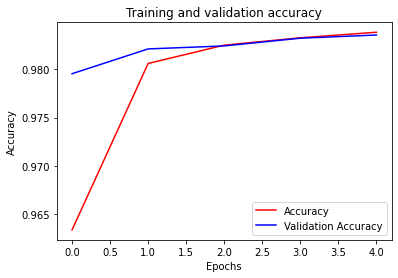

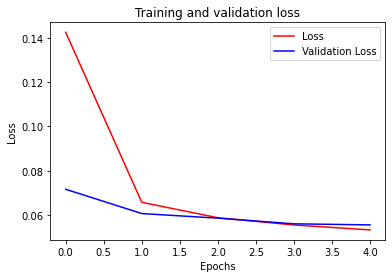

<Figure size 432x288 with 0 Axes>

In [52]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

## Lets Check some predictions

In [54]:
y_pred = model.predict([X_test,
                        y_test.reshape(*y_test.shape, 1)])


In [57]:
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [58]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], y_test[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
April          : B-tim B-tim
was            : O     O
a              : O     O
deadly         : O     O
month          : O     O
in             : O     O
Iraq           : B-geo B-geo
,              : O     O
with           : O     O
UNK            : O     O
Iraqis         : B-gpe B-gpe
reported       : O     O
killed         : O     O
in             : O     O
attacks        : O     O
.              : O     O
